/home/liyiming/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1699: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Finished reading the train set of Leaves Dataset (18353 samples found)
Training for fold 0/10...
loaded model from ../models/fold=0-model.pth for resume training with current_epoch=44
Epoch 44/100 training...


  0%|          | 0/130 [00:00<?, ?it/s]

9/130 loss:0.43794786632061006  acc:0.86953125
19/130 loss:0.42576044648885725  acc:0.865625


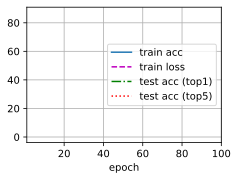

29/130 loss:0.4220929592847824  acc:0.8674479166666667
39/130 loss:0.40111181437969207  acc:0.8716796875
49/130 loss:0.38578126341104507  acc:0.87453125


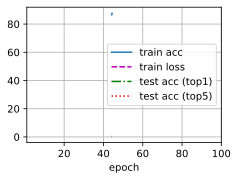

59/130 loss:0.37488710110386214  acc:0.8766927083333333
69/130 loss:0.36295539140701294  acc:0.8803571428571428


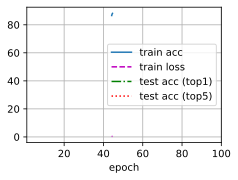

79/130 loss:0.36013217959553  acc:0.8814453125
89/130 loss:0.3550154328346252  acc:0.88203125
99/130 loss:0.34949162796139716  acc:0.883984375


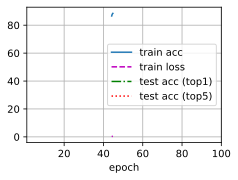

109/130 loss:0.34734066196463326  acc:0.8847301136363637
119/130 loss:0.3469796696056922  acc:0.8846354166666667
129/130 loss:0.3453966512470461  acc:0.8853302657867651


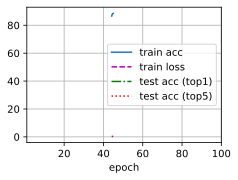

train loss:0.3453966512470461 acc:0.8853302657867651
acc:88.23529416751238 acc5:98.80174291938998


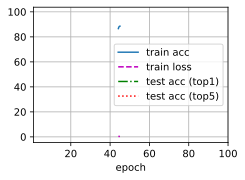

Epoch 45/100 training...


  0%|          | 0/130 [00:00<?, ?it/s]

9/130 loss:0.5890012055635452  acc:0.8203125
19/130 loss:0.5437668606638908  acc:0.8328125


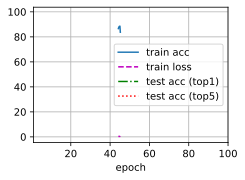

29/130 loss:0.5184356848398844  acc:0.8390625
39/130 loss:0.49840251430869104  acc:0.8421875
49/130 loss:0.47478536307811736  acc:0.8478125


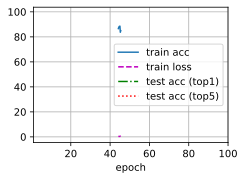

59/130 loss:0.4565063719948133  acc:0.8528645833333334
69/130 loss:0.44070269337722234  acc:0.8566964285714286


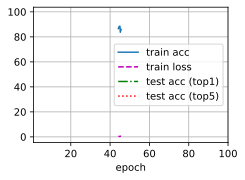

79/130 loss:0.42972945626825093  acc:0.859765625
89/130 loss:0.4250487259692616  acc:0.8605902777777777
99/130 loss:0.42092947944998743  acc:0.86078125


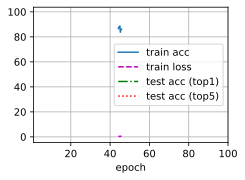

109/130 loss:0.4159217348152941  acc:0.8622869318181818
119/130 loss:0.4082482292006413  acc:0.864453125
129/130 loss:0.40267352858084543  acc:0.8664406369195374


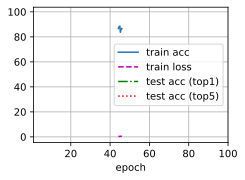

train loss:0.40267352858084543 acc:0.8664406369195374
acc:87.09150335108274 acc5:98.85620915032679


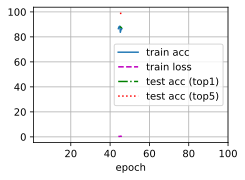

Epoch 46/100 training...


  0%|          | 0/130 [00:00<?, ?it/s]

9/130 loss:0.42881919592618944  acc:0.86640625
19/130 loss:0.45194013193249705  acc:0.85390625


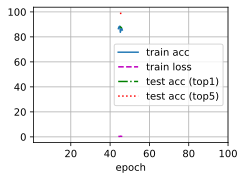

29/130 loss:0.4267007534702619  acc:0.8578125
39/130 loss:0.4068136289715767  acc:0.866015625
49/130 loss:0.3922096058726311  acc:0.87046875


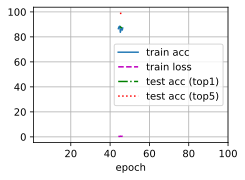

59/130 loss:0.38028018847107886  acc:0.8755208333333333
69/130 loss:0.3726539381912776  acc:0.8779017857142857


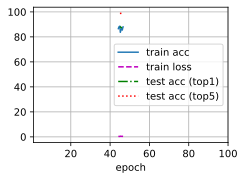

79/130 loss:0.36246621794998646  acc:0.8794921875
89/130 loss:0.3570578921172354  acc:0.8802951388888889
99/130 loss:0.34984432145953176  acc:0.882265625


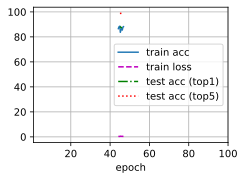

109/130 loss:0.34777955480597234  acc:0.8822443181818181
119/130 loss:0.3444286406040192  acc:0.8831380208333334
129/130 loss:0.3403483867616394  acc:0.8850275473754313


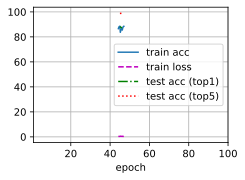

train loss:0.3403483867616394 acc:0.8850275473754313
acc:88.61655785055721 acc5:99.40087145969498


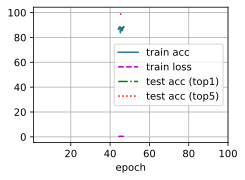

Epoch 47/100 training...


  0%|          | 0/130 [00:00<?, ?it/s]

9/130 loss:0.38946199864149095  acc:0.8703125
19/130 loss:0.3778267540037632  acc:0.875


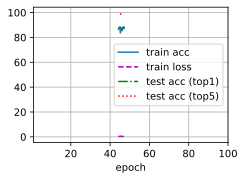

29/130 loss:0.39461290687322614  acc:0.8690104166666667
39/130 loss:0.3887995708733797  acc:0.871484375
49/130 loss:0.3770436945557594  acc:0.87453125


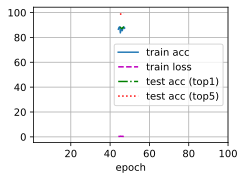

59/130 loss:0.36909713173906006  acc:0.8770833333333333
69/130 loss:0.3607275445546423  acc:0.8786830357142857


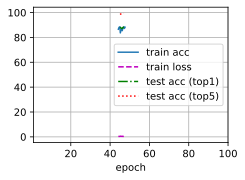

79/130 loss:0.3474319836124778  acc:0.8830078125
89/130 loss:0.3423491992884212  acc:0.884375


In [ ]:
from train import train

args = {
    'batch_size': 128,
    'model': 'seresnext50',
    'freeze': False,
    'eval_all': True,
    'data_root': '../dataset/classify-leaves',
    'val_ratio': 0.1,
    'fold': 10,
    'lr': 2e-5,
    'epoch': 100,
    'resume': True,
    'verbose': True,
    'ckpt_path': 'model.pth'
}
class AttributeDict(dict):
    __slots__ = () 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
args = AttributeDict(args)

train(args)